# Challenge 5: Classification

| Title        | Answer                     |
| :---------- | :------------------------ |
| Topic:       | Classification | 
| Date:        | 2016/07/31                 |
| Name:        | Michelle L. Gill           |
| Worked with: | None                       | 



In [1]:
import pandas as pd
import numpy as np
import cPickle as pickle

from sklearn.cross_validation import train_test_split

from sklearn.metrics import accuracy_score, f1_score

from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import cross_val_score

from sklearn.preprocessing import normalize, Normalizer
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

%matplotlib inline

## Question 1

Load the data into a pandas dataframe. Replace 'y's with 1s, 'n's with 0s.

Now, almost every representative has a ?. This represents the absence of a vote (they were absent or some other similar reason). If we dropped all the rows that had a ?, we would throw out most of our data. Instead, we will replace ? with the best guess in the Bayesian sense: in the absence of any other information, we will say that the probability of the representative saying YES is the ratio of others that said YES over the whole votes.

So, convert each ? to this probability (when yes=1 and no=0, this is the mean of the column)

In [2]:
! curl https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data -o 'voting_record.csv'
! head -n 3 voting_record.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18171  100 18171    0     0  27737      0 --:--:-- --:--:-- --:--:-- 40380
republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n


Replace 'y' and 'n' values.

In [3]:
vote_cols = ['v{}'.format(x) for x in range(1,17)]
all_cols = ['party'] + vote_cols

votes = pd.read_csv('voting_record.csv', 
                    header=None, 
                    names=all_cols)

votes = votes.replace('y', 1).replace('n', 0).replace('?', np.NaN)
votes.head(3)

,party,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


Compute the probability of a yes or no vote.

In [4]:
vote_totals = (pd.Series(votes[vote_cols].values.ravel())
               .dropna()
               .astype(int)
               .value_counts()
               )

vote_totals /= vote_totals.sum()
p_yes = vote_totals.loc[1]

print vote_totals
print p_yes

1    0.520859
0    0.479141
dtype: float64
0.520858708892


Compute a binomial distribution with `p_yes` of being true and use this to fill the missing votes.

In [5]:
def vote_filler(df_col, p_yes=p_yes):
    mask = df_col.isnull()
    fill_size = mask.sum()
    df_col.loc[mask] = np.random.binomial(1, p=p_yes, size=fill_size)
    return df_col

votes[vote_cols] = votes[vote_cols].apply(vote_filler, axis=0).astype(int)
votes.head(3)

,party,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16
0,republican,0,1,0,1,1,1,0,0,0,1,0,1,1,1,0,1
1,republican,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,1
2,democrat,1,1,1,1,1,1,0,0,0,0,1,0,1,1,0,0


## Question 2

Split the data into a test and training set.

In [6]:
train, test = train_test_split(votes, test_size=0.3, random_state=4444)
test.to_pickle('votes_test.pkl')
votes.to_pickle('votes.pkl')

## Question 3

Using scikit.learn's KNN algorithm, train a model that predicts the party (republican/democrat).

Try it with a lot of different k values (number of neighbors), from 1 to 20, and on the test set calculate the accuracy (number of correct predictions / number of all predictions) for each k

In [7]:
# I believe that this data should not need to be normalized for KNN since all features are
# already on the same scale [0, 1]

df_list = list()

for k in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train[vote_cols], train['party'])
    
    accuracy_train = accuracy_score(train['party'],  knn.predict(train[vote_cols]))
    accuracy_test = accuracy_score(test['party'],  knn.predict(test[vote_cols]))
    
    df_list.append(pd.DataFrame({'accuracy_train':accuracy_train,
                                 'accuracy_test':accuracy_test,
                                 'model':knn},
                               index=pd.Index([k], name='k_size'),
                               columns=['accuracy_train', 'accuracy_test', 'model']))
    
knn_df = pd.concat(df_list).reset_index()

Which k value gives the highest accuracy?

### Answer
For k-nearest-neighbors, k=7 gives the highest accuracy.

In [8]:
knn_best_model = knn_df.loc[knn_df.accuracy_test.argmax(),'model']

with open('knn_house.mdl','w') as fh:
    pickle.dump(knn_best_model, fh)

knn_df.loc[knn_df.accuracy_test.argmax()]

k_size                                                            1
accuracy_train                                                    1
accuracy_test                                              0.931298
model             KNeighborsClassifier(algorithm='auto', leaf_si...
Name: 0, dtype: object

## Question 4

Make a similar model but with `LogisticRegression` instead, calculate test accuracy.

In [9]:
df_list = list()

for C in [1000, 10, 1, 0.1, 0.01, 0.001]:
    log = LogisticRegression(C=C, penalty='l2', tol=0.01)
    log.fit(train[vote_cols], train['party'])

    accuracy_train = accuracy_score(train['party'], log.predict(train[vote_cols]))
    accuract_test = accuracy_score(test['party'], log.predict(test[vote_cols]))
    
    df_list.append(pd.DataFrame({'accuracy_train': accuracy_train,
                                 'accuracy_test': accuract_test,
                                 'model':log},
                                index=pd.Index([C], name='C'),
                                columns=['accuracy_train', 'accuracy_test', 'model']))
    
logit_df = pd.concat(df_list).reset_index()
logit_df

,C,accuracy_train,accuracy_test,model
0,1000.000,0.976974,0.946565,"LogisticRegression(C=1000, class_weight=None, ..."
1,10.000,0.976974,0.946565,"LogisticRegression(C=10, class_weight=None, du..."
2,1.000,0.980263,0.931298,"LogisticRegression(C=1, class_weight=None, dua..."
3,0.100,0.947368,0.931298,"LogisticRegression(C=0.1, class_weight=None, d..."
4,0.010,0.907895,0.885496,"LogisticRegression(C=0.01, class_weight=None, ..."
5,0.001,0.888158,0.839695,"LogisticRegression(C=0.001, class_weight=None,..."


In [10]:
log_best_model = logit_df.loc[logit_df.accuracy_test.argmax(),'model']

with open('log_house.mdl','w') as fh:
    pickle.dump(log_best_model, fh)

logit_df.loc[logit_df.accuracy_test.argmax()]

C                                                              1000
accuracy_train                                             0.976974
accuracy_test                                              0.946565
model             LogisticRegression(C=1000, class_weight=None, ...
Name: 0, dtype: object

## Question 5

Make a bar graph of democrats and republicans. How many of each are there?

Make a very simple predictor that predicts 'democrat' for every incoming example.

Just make a function that takes in an X --an array or matrix with input examples--, and returns an array of the same length as X, where each value is 'democrat'. For example, if X is three rows, your function should return ['democrat','democrat','democrat']. Make a y_predicted vector using this and measure its accuracy.

Do the same with predicting 'republican' all the time and measure its accuracy.

In [11]:
votes['party'].value_counts()

democrat      267
republican    168
Name: party, dtype: int64

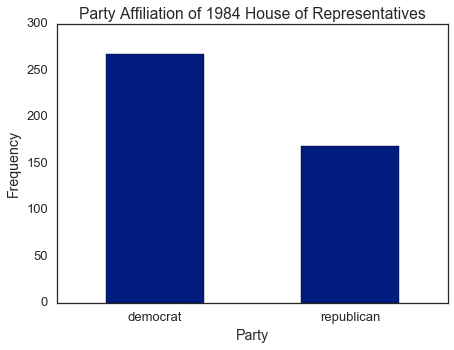

In [12]:
ax = votes['party'].value_counts().plot(kind='bar', figsize=(7,5))
_ = plt.xticks(rotation=0)
_ = ax.set(xlabel='Party', 
           ylabel='Frequency', 
           title='Party Affiliation of 1984 House of Representatives')

In [13]:
def predict_same_party(xdata, predict='democrat'):
    return np.array([predict]*xdata.shape[0])

In [14]:
y_dem = predict_same_party(train)
y_dem_accuracy = accuracy_score(train['party'], y_dem)
y_dem_accuracy

0.625

In [15]:
y_repub = predict_same_party(train, 'republican')
y_repub_accuracy = accuracy_score(train['party'], y_repub)
y_repub_accuracy

0.375

## Question 6

Plot the accuracies as a function of k. Since k only matters for KNN, your logistic regression accuracy, 'democrat' predictor accuracy and 'republican' predictor accuracy will stay the same over all k, so each of these three will be a horizontal line. But the KNN accuracy will change with k.

(0, 1)

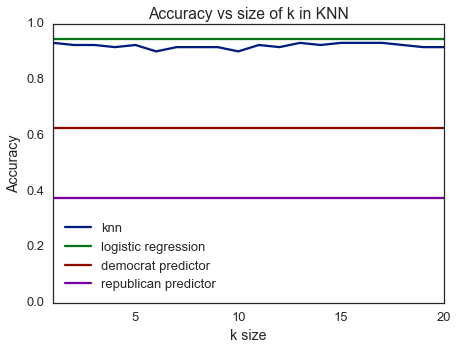

In [16]:
ax = knn_df.plot('k_size', 'accuracy_test', figsize=[7,5])

logit_accuracy = logit_df.loc[logit_df.accuracy_test.argmax(), 'accuracy_test']
ax.plot(knn_df.k_size, [logit_accuracy]*len(knn_df.k_size), label='logistic regression')
ax.plot(knn_df.k_size, [y_dem_accuracy]*len(knn_df.k_size), label='democrat predictor')
ax.plot(knn_df.k_size, [y_repub_accuracy]*len(knn_df.k_size), label='republican predictor')

labels = ['knn', 'logistic regression', 'democrat predictor', 'republican predictor']
legend = ax.legend(loc=0)
_ = [x[1].set_text(labels[x[0]]) for x in enumerate(legend.get_texts())]
_ = ax.set(xlabel='k size', ylabel='Accuracy', title='Accuracy vs size of k in KNN')
ax.set_ylim(0,1)

## Question 7

Plot a learning curve for the logistic regression model and for KNN.

In [17]:
log_train_sizes, log_train_scores, log_test_scores = learning_curve(log_best_model, 
                                                                    votes[vote_cols], 
                                                                    votes['party'],
                                                                    np.linspace(0.1, 1.0, 19))

log_train_scores = log_train_scores.mean(axis=1)
log_test_scores = log_test_scores.mean(axis=1)

knn_train_sizes, knn_train_scores, knn_test_scores = learning_curve(knn_best_model, 
                                                                    votes[vote_cols], 
                                                                    votes['party'],
                                                                    np.linspace(0.1, 1.0, 19))

knn_train_scores = knn_train_scores.mean(axis=1)
knn_test_scores = knn_test_scores.mean(axis=1)

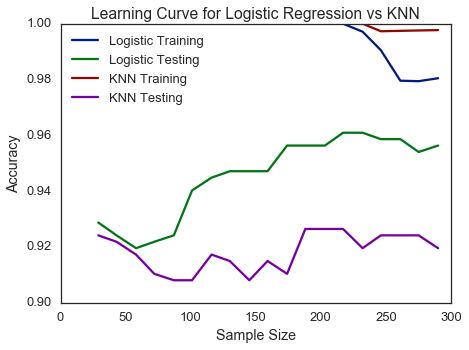

In [18]:
f = plt.figure()
f.set_size_inches(7,5)
ax = plt.axes()

ax.plot(log_train_sizes, log_train_scores, label='Logistic Training')
ax.plot(log_train_sizes, log_test_scores, label='Logistic Testing')
ax.plot(knn_train_sizes, knn_train_scores, label='KNN Training')
ax.plot(knn_train_sizes, knn_test_scores, label='KNN Testing')
ax.legend(loc=0)
_ = ax.set(xlabel='Sample Size', 
       ylabel='Accuracy',
       title='Learning Curve for Logistic Regression vs KNN')

## Question 8

This is a preview of many other classification algorithms that we will go over. Scikit.learn has the same interface for all of these, so you can use them exactly the same way as you did LogisticRegression and KNeighborsClassifier. Use each of these to classify your data and print the test accuracy of each.

In [19]:
algo_list = list()

for algo in enumerate(['GaussianNB', 'SVC', 
                       'DecisionTreeClassifier', 'RandomForestClassifier']):
    model = eval(algo[1]+'()')
    model.fit(train[vote_cols], train['party'])

    accuracy_train = accuracy_score(train['party'], model.predict(train[vote_cols]))
    accuracy_test = accuracy_score(test['party'], model.predict(test[vote_cols]))
    
    if algo[1] == 'RandomForestClassifier':
        model = tuple([model])
        
    algo_list.append(pd.DataFrame({'classifier': algo[1],
                                   'accuracy_train': accuracy_train,
                                   'accuracy_test': accuracy_test,
                                   'model': model},
                                index=pd.Index([algo[0]], name='index'),
                                columns=['classifier', 'accuracy_train', 
                                         'accuracy_test', 'model']))
    
    with open(algo[1].lower()+'_house.mdl','w') as fh:
        pickle.dump(model, fh)

In [20]:
algo_df = pd.concat(algo_list, axis=0)
algo_df

,classifier,accuracy_train,accuracy_test,model
index,,,,
0,GaussianNB,0.927632,0.946565,GaussianNB()
1,SVC,0.976974,0.954198,"SVC(C=1.0, cache_size=200, class_weight=None, ..."
2,DecisionTreeClassifier,1.000000,0.938931,"DecisionTreeClassifier(class_weight=None, crit..."
3,RandomForestClassifier,0.996711,0.908397,"(DecisionTreeClassifier(class_weight=None, cri..."


## Question 9

Use `cross_val_score` to calculate the cross validation score of each of the classifiers you tried before.

In [21]:
cv_list = list()

for idx,dat in algo_df.iterrows():
    model = dat.model
    label = dat.classifier
    cv_val = cross_val_score(model, train[vote_cols], train['party'])
    df = pd.Series({'label':label, 'cv':cv_val.mean()})
    cv_list.append(df)

In [22]:
pd.concat(cv_list, axis=1).T[['label','cv']]

,label,cv
0,GaussianNB,0.924513
1,SVC,0.960655
2,DecisionTreeClassifier,0.940756
3,RandomForestClassifier,0.934285


## Question 10

Instead of 'democrat' or 'republican', can you predict the vote of a representative based on their other votes?

In [23]:
vote_cols = ['v{}'.format(x) for x in range(1,17)]
all_cols = ['party'] + vote_cols

votes2 = pd.read_csv('voting_record.csv', 
                    header=None, 
                    names=all_cols)

votes2 = votes2.replace('y', 1).replace('n', 0).replace('?', np.NaN)

In [24]:
# Before prediction, fill NaNs with the mode of each column
votes2 = votes2.fillna(votes2.mode().iloc[0])
votes2[vote_cols] = votes2[vote_cols].astype(int)

In [25]:
df_list = list()
log = LogisticRegression()

for col in vote_cols:
    label_col = col
    data_cols = [x for x in vote_cols if x!=label_col]
    
    df_list.append((label_col, cross_val_score(log, 
                                   votes2[data_cols], 
                                   votes2[label_col], cv=4).mean())
                  )

In [26]:
pd.DataFrame(df_list, columns=['label','CV_accuracy'])

,label,CV_accuracy
0,v1,0.685015
1,v2,0.639186
2,v3,0.866611
3,v4,0.901160
4,v5,0.926329
5,v6,0.832165
6,v7,0.871110
7,v8,0.891774
8,v9,0.875633
9,v10,0.482671


## Question 11

Back to movie data! Choose one categoric feature to predict. I chose MPAA Rating, but genre, month, etc. are all decent choices. If you don't have any non-numeric features, you can make two bins out of a numeric one (like "Runtime>100 mins" and "Runtime<=100 mins")

In [28]:
movies = pd.read_csv('../../../challenges_data/2013_movies.csv').dropna()

In [29]:
knn_list = list()

feat_cols = ['Budget', 'DomesticTotalGross', 'Runtime']
movies[feat_cols] = Normalizer().fit_transform(movies[feat_cols])
mtrain, mtest = train_test_split(movies, test_size=0.3, random_state=4444)

for k in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(mtrain[feat_cols], mtrain['Rating'])
    
    Ytest = mtest['Rating']
    Ypred = knn.predict(mtest[feat_cols])

    accuracy_knn = accuracy_score(Ytest, Ypred)
    
    simple_predict = [mtest.Rating.value_counts().argmax()]*Ytest.shape[0]
    accuracy_simple = accuracy_score(Ytest, simple_predict)

    df = pd.Series({'data':label, 'k':k,
                    'accuracy_knn':accuracy_knn,
                    'accuracy_simple':accuracy_simple,
                    'model':knn})
    
    knn_list.append(df)

In [30]:
knn_df = pd.concat(knn_list, axis=1).T
knn_df[['data','k','accuracy_knn','accuracy_simple']]

,data,k,accuracy_knn,accuracy_simple
0,RandomForestClassifier,1,0.37037,0.407407
1,RandomForestClassifier,2,0.333333,0.407407
2,RandomForestClassifier,3,0.407407,0.407407
3,RandomForestClassifier,4,0.37037,0.407407
4,RandomForestClassifier,5,0.444444,0.407407
5,RandomForestClassifier,6,0.444444,0.407407
6,RandomForestClassifier,7,0.444444,0.407407
7,RandomForestClassifier,8,0.444444,0.407407
8,RandomForestClassifier,9,0.444444,0.407407
9,RandomForestClassifier,10,0.444444,0.407407


In [31]:
knn_best_model = knn_df.loc[knn_df.accuracy_knn.argmax(),'model']

with open('knn_movie.mdl','w') as fh:
    pickle.dump(knn_best_model, fh)

In [32]:
log_list = list()

LR = LogisticRegression()
LR.fit(mtrain[feat_cols], mtrain['Rating'])

Ytest = mtest['Rating']
Ypred = LR.predict(mtest[feat_cols])

accuracy = accuracy_score(Ytest, Ypred)

df = pd.Series({'data':label,
                'accuracy':accuracy,
                'model':LR})

log_list.append(df)

In [33]:
with open('log_movie.mdl','w') as fh:
    pickle.dump(LR, fh)

In [34]:
log_list

[accuracy                                             0.333333
 data                                   RandomForestClassifier
 model       LogisticRegression(C=1.0, class_weight=None, d...
 dtype: object]

In [35]:
LR.coef_

array([[ -2.92661261e-01,  -7.31121786e-01,  -2.22492520e-06],
       [  9.24127469e-01,  -7.40087199e-01,  -6.16070237e-06],
       [ -1.29643939e+00,   6.10423441e-01,   7.06882779e-06]])

## Question 12

Now you are a classification master. The representative votes dataset only had 0s and 1s. Let's just swiftly tackle the breast cancer surgery data.

In [55]:
! curl https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data  -o 'haberman.data'
! curl https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.names  -o 'haberman.names'    

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3103  100  3103    0     0   8283      0 --:--:-- --:--:-- --:--:--  8363
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1368  100  1368    0     0   3707      0 --:--:-- --:--:-- --:--:--  3737


In [78]:
hab = pd.read_csv('haberman.data',names=['age_op','year_op','num_nodes','survival'])

Age and standard deviation of all patients

In [79]:
hab.age_op.mean(),hab.age_op.std() 

(52.457516339869279, 10.80345234930328)

Age and standard deviation of patients who survived more than 5 years.

In [80]:
surv = hab.loc[hab.survival==1,'age_op']
surv.mean(), surv.std()

(52.017777777777781, 11.012154179929542)

Age and standard deviation of patients who survived less than 5 years.

In [81]:
no_surv = hab.loc[hab.survival==2,'age_op']
no_surv.mean(), no_surv.std()

(53.679012345679013, 10.167137208297412)

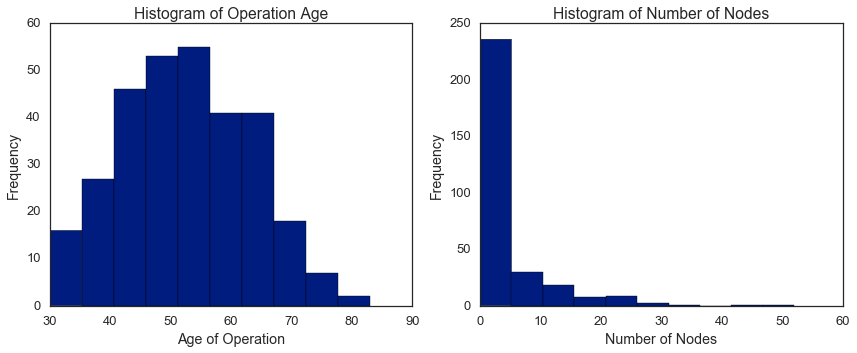

In [82]:
fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(12,5)

ax = axList[0]
hab.age_op.hist(ax=ax)
ax.grid('off')
ax.set(xlabel='Age of Operation', ylabel='Frequency', title='Histogram of Operation Age')

ax = axList[1]
hab.num_nodes.hist(ax=ax)
ax.grid('off')
ax.set(xlabel='Number of Nodes', ylabel='Frequency', title='Histogram of Number of Nodes')

plt.tight_layout()

Earliest and most recent year of surgery.

In [83]:
hab.year_op.min(), hab.year_op.max()

(58, 69)

In [84]:
feat_cols = ['age_op','year_op','num_nodes']

#hab[feat_cols] = Normalizer().fit_transform(hab[feat_cols])
train, test = train_test_split(hab, test_size=0.3, random_state=4444)

LR = LogisticRegression()
LR.fit(train[feat_cols], train['survival'])

Ytest = test['survival']
Ypred = LR.predict(test[feat_cols])

train.to_pickle('haberman_train.pkl')
test.to_pickle('haberman_test.pkl')
with open('LR_haberman.pkl', 'w') as fh:
    pickle.dump(LR, fh)

In [85]:
accuracy = accuracy_score(Ytest, Ypred)
f1 = f1_score(Ytest, Ypred)
print accuracy, f1

0.815217391304 0.89696969697


Age of operation and number of nodes are positively correlated with survival, which isn't that surprising. Year of operation is inversely correlated with survival--interesting.

In [86]:
LR.coef_

array([[ 0.0155515 , -0.02899279,  0.07136197]])

In [87]:
train_sizes, train_scores, test_scores = learning_curve(LR, 
                                                        test[feat_cols], 
                                                        test['survival'],
                                                        np.linspace(0.1, 1.0, 19))


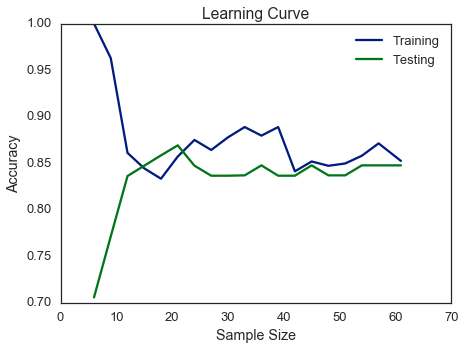

In [77]:
f = plt.figure()
f.set_size_inches(7,5)
ax = plt.axes()

ax.plot(train_sizes, train_scores.mean(axis=1), label='Training')
ax.plot(train_sizes, test_scores.mean(axis=1), label='Testing')
ax.legend(loc=0)
_ = ax.set(xlabel='Sample Size', 
       ylabel='Accuracy',
       title='Learning Curve')